In [1]:
import os 
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools.retriever import create_retriever_tool
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated, Sequence, Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
load_dotenv()

/Users/kmk/Desktop/langchain/langchain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
AZURE_DEPLOYMENT_NAME = os.getenv('AZURE_DEPLOYMENT_NAME')
AZURE_API_VERSION = os.getenv('AZURE_API_VERSION')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Agentic-RAG'

In [3]:
llm = AzureChatOpenAI(
    model='gpt-4.1-mini',
    azure_endpoint=AZURE_API_ENDPOINT,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    api_version=AZURE_API_VERSION
)

#### Vector database tool for langraph

In [4]:
urls = [
    "https://docs.langchain.com/oss/python/langgraph/overview",
    "https://docs.langchain.com/oss/python/langgraph/workflows-agents",
    "https://docs.langchain.com/oss/python/langgraph/thinking-in-langgraph"
]

In [5]:
docs = [WebBaseLoader(urls).load() for url in urls]

In [6]:
doc_list = [item for sublist in docs for item in sublist]

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_split = text_splitter.split_documents(doc_list)

In [8]:
embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-small",
    azure_endpoint=AZURE_API_ENDPOINT)

In [9]:
vector_store = Chroma.from_documents(doc_split, embeddings, collection_name='langgraph_db')

In [10]:
retriver = vector_store.as_retriever()

In [73]:
langgraph_retriver_tool = create_retriever_tool(
    retriver,
    "retriver_vector_db_blog",
    "Search and run information about langgraph"
)

#### vector database tool for langchain

In [13]:
urls = [
    "https://docs.langchain.com/oss/python/langchain/overview",
    "https://docs.langchain.com/oss/python/langchain/agents",
    "https://docs.langchain.com/oss/python/langchain/tools"
]

In [14]:
docs = [WebBaseLoader(url).load() for url in urls]

In [15]:
docs_list = [item for sublist in docs for item in sublist]

In [16]:
doc_split = text_splitter.split_documents(docs_list)

In [17]:
vector_store_lc = Chroma.from_documents(doc_split, embeddings, collection_name='langgraph_db')

In [18]:
retriver_langchain = vector_store_lc.as_retriever()

In [72]:
langchain_retriver_tool = create_retriever_tool(
    retriver_langchain,
    "retriver_vector_langchain_blog",
    "Search and run information about langchain"
)

In [74]:
tools = [langgraph_retriver_tool, langchain_retriver_tool]

In [28]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [29]:
def agent(state:AgentState):
    """
    Invokes the agent model to generate a response based on the current state. Given the question, it will decide to retrieve using the retriever tool, or simply end
    
    Args:
        state(messages): The current state 
        
    Returns:
        dict: The updated state with the agent response appended to messages    
    """
    print('---Call Agent---')
    messages = state['messages']
    llm_with_models = llm.bind_tools(tools)
    response = llm_with_models.invoke(messages)
    return {'messages': [response]}

In [52]:
def grade_documents(state:AgentState) -> Literal["generate", "rewrite"]:
    """Determines whether the retrieved documents are relevant to the question
    
    Args: 
        state (messages): the current state 
    Returns: 
        str: A decision for whether the documents are relevant ot not"""
    
    print("---Check Relevance---")
    
    class grade(BaseModel):
        """
        Binary score for relevance check
        """
        
        binary_score: str = Field(description="Relavance score 'yes' or 'no'")
        
    llm_with_tool = llm.with_structured_output(grade)
    
    prompt = PromptTemplate(
        template = """You are a grader assessing relevance of a retrieved document to a user question.\n
        Here is the retrived document: \n\n {context} \n\n
        Here is the user question: {question} \n 
        If the document contains keyword(s) or semantic meaing related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question""",
        input_variables = ["context", "question"],
    )
    
    chain = prompt | llm_with_tool 
    
    messages = state['messages']
    last_message = messages[-1]
    
    question = messages[0].content 
    docs = last_message.content
    
    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score 
    
    if score == 'yes':
        print('---Decision: Docs Relevant---')
        return "generate"
    else:
        print("---Decision: Docs not relevant---")
        print(score)
        return "rewrite"

In [54]:
def generate(state:AgentState):
    """
    Generate answer
    
    Args:
        state(messages): the current state 
        
    Returns:
        dict: The updated message 
    """
    print("--Generate--")
    messages = state['messages']
    question = messages[0].content 
    last_message = messages[-1]
    docs = last_message.content 
    
    '''prompt = hub.pull('rlm/rag-prompt')
    
    def format_docs(docs):
        return '\n\n'.join(doc.page_content for doc in docs)
        
    rag_chain = prompt | llm | StrOutputParser()
    
    response = rag_chain.invoke({'context': docs, 'question': question}) '''
    
    return {'messages': [docs]}
    

In [55]:
def rewrite(state:AgentState):
    
    print("---Transform query---")
    messages = state['messages']
    question = messages[0].content
    
    msg = [
        HumanMessage(content=f"""\n
                     Look at the input and try to reason aboyt the underlying semantic intent/meaning.\n
                     Here is the initial question: 
                     \n---------\n
                     {question}
                     \n--------\n
                     Formulate an improved question:""")
    ]
    
    response = llm.invoke(msg)
    return {'messages': [response]}

In [77]:
workflow = StateGraph(AgentState)

workflow.add_node('agent', agent)
workflow.add_node("retriver", ToolNode(tools))
workflow.add_node('generate',generate)
workflow.add_node('rewrite', rewrite)


workflow.add_edge(START, 'agent')
workflow.add_conditional_edges(
    'agent',
    tools_condition,
    {
        "tools": "retriver",
        END:END
    }
)
workflow.add_conditional_edges(
    "retriver",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()

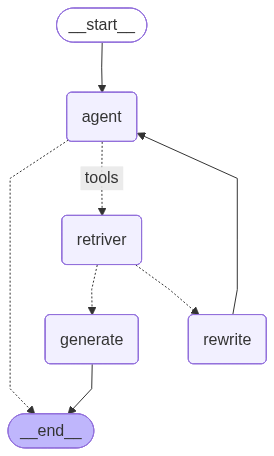

In [83]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [88]:
response = graph.invoke({"messages": "what is langgraph"})

---Call Agent---
---Check Relevance---
---Decision: Docs Relevant---
--Generate--


In [91]:
print(response["messages"][-1].content)

​LangGraph ecosystem
While LangGraph can be used standalone, it also integrates seamlessly with any LangChain product, giving developers a full suite of tools for building agents. To improve your LLM application development, pair LangGraph with:
LangSmithTrace requests, evaluate outputs, and monitor deployments in one place. Prototype locally with LangGraph, then move to production with integrated observability and evaluation to build more reliable agent systems.Learn moreLangGraphDeploy and scale agents effortlessly with a purpose-built deployment platform for long running, stateful workflows. Discover, reuse, configure, and share agents across teams — and iterate quickly with visual prototyping in Studio.Learn moreLangChainProvides integrations and composable components to streamline LLM application development. Contains agent abstractions built on top of LangGraph.Learn more
​Acknowledgements

​LangGraph ecosystem
While LangGraph can be used standalone, it also integrates seamlessly

In [86]:
graph.invoke({"messages": "what is langchain"})

---Call Agent---
---Check Relevance---
---Decision: Docs Relevant---
--Generate--


{'messages': [HumanMessage(content='what is langchain', additional_kwargs={}, response_metadata={}, id='d20c372d-dd0d-42d1-b44f-b5117861779a'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 96, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_3dcd5944f5', 'id': 'chatcmpl-CgsIDrd5t2bCHrIbRjEiaUeQZjAMg', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}

In [87]:
graph.invoke({"messages": "what is Machine Learning"})

---Call Agent---


{'messages': [HumanMessage(content='what is Machine Learning', additional_kwargs={}, response_metadata={}, id='c7b58643-95fe-49ba-9f8c-06951d2cc806'),
  AIMessage(content='Machine Learning is a field of artificial intelligence (AI) that focuses on the development of algorithms and statistical models that enable computers to learn from and make predictions or decisions based on data. Instead of being explicitly programmed to perform a task, machine learning systems improve their performance on tasks through experience and exposure to data. It is widely used in various applications such as image and speech recognition, recommendation systems, fraud detection, and autonomous vehicles.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 96, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'au